# ASR I: Seminar

In [ ]:
# %%capture pip_install_requirements_output
%pip install --quiet --upgrade -r requirements.txt

In [1]:
import os
import random
import urllib
from typing import List, Iterable

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import nltk
import numpy as np
import requests
import seaborn as sns
import sentencepiece as spm
import torch
import torchaudio
from g2p_en import G2p

data_directory = './week_04_data'

In [2]:
%load_ext autoreload
%autoreload 2

import utils

In [ ]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/KqloT1zKr_2VaA'
final_url = base_url + urllib.parse.urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']
!wget -O week_04_data.tar.gz "{download_url}"
!mkdir -p week_04_data
!tar -xf week_04_data.tar.gz -C week_04_data

## Acoustic features

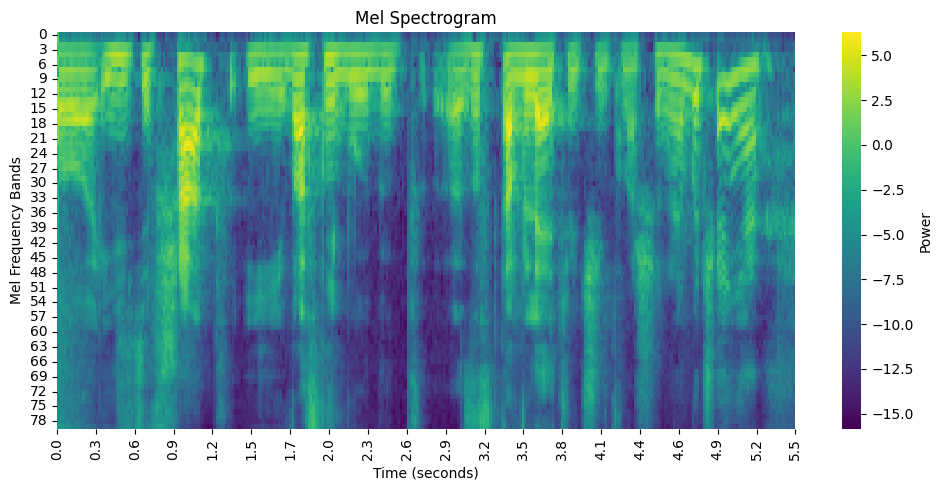

In [3]:
target_sample_rate = 16_000

waveform, sample_rate = torchaudio.load(os.path.join(data_directory, 'babenko.wav'))

resample_waveform = torchaudio.transforms.Resample(
    sample_rate,
    target_sample_rate,
)

wav_to_melspec = torchaudio.transforms.MelSpectrogram(
    sample_rate=target_sample_rate,
    n_mels=80,
)

melspec = wav_to_melspec(resample_waveform(waveform))[0]

# plotting
plt.figure(figsize=(10, 5))
melspec_log = (torch.log(melspec + 1e-9)).numpy()
ax = sns.heatmap(melspec_log, cmap='viridis', cbar_kws={'label': 'Power'})

num_ticks = 20
time_ticks = np.linspace(0, melspec_log.shape[1], num_ticks)
time_labels = [f"{t:.1f}" for t in np.linspace(0, waveform.shape[1] / target_sample_rate, num_ticks)]
ax.set_xticks(time_ticks)
ax.set_xticklabels(time_labels)

plt.xlabel('Time (seconds)')
plt.ylabel('Mel Frequency Bands')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()

## Speech units

In [4]:
text = 'you will not be forced to learn machine learning'

words = text.split(' ')

graphemes = list(text)

nltk.download('averaged_perceptron_tagger_eng', quiet=True)
grapheme_to_phoneme_model = G2p()
phonemes = grapheme_to_phoneme_model(text)

subword_model = spm.SentencePieceProcessor(model_file=os.path.join(data_directory, 'sentencepiece.bpe.model'))  # https://huggingface.co/facebook/s2t-small-librispeech-asr/blob/main/sentencepiece.bpe.model
subwords = subword_model.EncodeAsPieces(text, enable_sampling=False)

print(f'{text = }\n{words = }\n{graphemes = }\n{phonemes = }\n{subwords = }')

text = 'you will not be forced to learn machine learning'
words = ['you', 'will', 'not', 'be', 'forced', 'to', 'learn', 'machine', 'learning']
graphemes = ['y', 'o', 'u', ' ', 'w', 'i', 'l', 'l', ' ', 'n', 'o', 't', ' ', 'b', 'e', ' ', 'f', 'o', 'r', 'c', 'e', 'd', ' ', 't', 'o', ' ', 'l', 'e', 'a', 'r', 'n', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e', ' ', 'l', 'e', 'a', 'r', 'n', 'i', 'n', 'g']
phonemes = ['Y', 'UW1', ' ', 'W', 'IH1', 'L', ' ', 'N', 'AA1', 'T', ' ', 'B', 'IY1', ' ', 'F', 'AO1', 'R', 'S', 'T', ' ', 'T', 'UW1', ' ', 'L', 'ER1', 'N', ' ', 'M', 'AH0', 'SH', 'IY1', 'N', ' ', 'L', 'ER1', 'N', 'IH0', 'NG']
subwords = ['▁you', '▁will', '▁not', '▁be', '▁forc', 'ed', '▁to', '▁learn', '▁machine', '▁learn', 'ing']


## Metrics

Word (Character, Phoneme) Error Rate (WER/CER/PER) – are the most popular metrics, which try to approximate how we perceive errors in the speech we hear. We will:
- learn to calculate each of these distances using the Levenstein distance
- implement both a naive recursive version of the Levenstein algorithm as well as a more efficient dynamic-programming implementation
- using implementation of Levenstein distance you wil compute ASR quality metrics.

### Levenshtein distance

Consider an iterable sequence of elements, such as word or characters. Assume that the following operations can be performed on the sequence:
* **insertion**: cat → ca<font color='green'>s</font>t,
* **deletion**: ca<font color='red'>s</font>t → cat,
* **substitution**: c<font color='blue'>a</font>t → c<font color='blue'>u</font>t,

and suppose they have equal **costs**. These operations are enough to translate an arbitrary sequence into a different arbitrary sequence. There are many ways in which we can transform (edit) the sequence into a difference sequence. Given two sequences A and B, our goal is to find the minimum number of edits which are needed to transform sequence A into sequence B. This is known as the **Levenstein Distance**.

<!-- ### Algorithm definition -->

**Levenshtein distance** – the minimum number insertions, deletions, and substitutions required to transform sequence A into sequence B.


The Levenstein distance can be computed using the following recursive algorithm, known as the **Levenstein Algorithm**:

$$
\mathrm{L}(a, b) =
\begin{cases}
    |a|,& \text{if } |b| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{\# second sequence is empty} \\
    |b|,& \text{if } |a| = 0, ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{\# first sequence is empty} \\
    \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)),& \text{if } \mathrm{head}(a) = \mathrm{head}(b), ~ ~ \text{\# first elements of two sequencies are equal} \\
    1 + min 
    \begin{cases} 
        \mathrm{L}(\mathrm{tail}(a), b), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{\# deletion from first sequence} \\ 
        \mathrm{L}(a, \mathrm{tail}(b)), ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ ~ \text{\# insertion into first sequence} \\ 
        \mathrm{L}(\mathrm{tail}(a), \mathrm{tail}(b)); ~ ~ ~ ~ \text{\# substitution}
    \end{cases} & \text{, otherwise.}
\end{cases}
$$

<!-- %%
\text{lev}(a,b) = \left \{
  \begin{aligned}
    &\text{len}(a), & \text(del)& &&\text{if}\ \text{len}(b)=0, \\
    &\text{len}(b), & \text(ins)& &&\text{if}\ \text{len}(a)=0, \\
    &\text{lev}(a[1:],b[1:]) & \text(cor)& &&\text{if}\ a[0] = b[0], \\
    &1+\min\left \{
  \begin{aligned}
    &\text{lev}(a[1:],b) & \text(del)\\
    &\text{lev}(a,b[1:]) & \text(ins)\\
    &\text{lev}(a[1:],b[1:]) & \text(sub/cor)
  \end{aligned} \right. && &&\text{otherwise}
  \end{aligned} \right.
%% -->

As you can see, the Levenshtein distance is a metric in the mathematical sense (symmetry, positive certainty, triangle inequality).

**Question: what is the complexity of this algorithm?**

### Naive recursive implementation

Let's try to implement the recursive algorithm described above.

In [5]:
def levenshtein_naive(a: Iterable, b: Iterable) -> int:
    """Recursive implementation of Levenshtein distance

    :param a: Iterable
    :param b: Iterable
    :return distance: int
    """

    #############################################
    # <YOUR CODE>
    if len(a) == 0:
        return len(b)
    if len(b) == 0:
        return len(a)
    if a[0] == b[0]:
        return levenshtein_naive(a[1:], b[1:])
    return 1 + min(
        levenshtein_naive(a[1:], b),
        levenshtein_naive(a, b[1:]),
        levenshtein_naive(a[1:], b[1:]),
    )
    #############################################

In [6]:
# Assess algorithm correctness
def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3

run_tests(levenshtein_naive)

###  Wagner–Fischer algorithm

The complexity of the naive recursive implementation of the Levenshtein distance algorithm is exponential. This is due to the fact that the distances for the same suffixes are recalculated more than once! This can be avoided if we cache the results of calculations in the form of a matrix of distances between suffixes (more conveniently, prefixes), and fill in this matrix iteratively. The resulting algorithm is named **Wagner–Fischer algorithm** and is an example of a __dynamic programming__ algorithm.

The Wagner-Fisher algorithm is defined as follows:


$$
  \mathrm{L}_{a,b}(i,j) = \left \{
  \begin{aligned}
    &\max(i,j), && &&\text{if}\ \min(i,j)=0, \\
    &\min\left \{
  \begin{aligned}
    &\mathrm{L}_{a,b}(i-1,j)+1 & \text(del)\\
    &\mathrm{L}_{a,b}(i,j-1)+1 & \text(ins)\\
    &\mathrm{L}_{a,b}(i-1,j-1)+\delta(a_i \neq b_j) & \text(sub)
  \end{aligned} \right. && &&\text{otherwise}
  \end{aligned} \right.
$$


**Implement** the `levenshtein_distance_matrix` function, which returns **the distance matrix between the prefixes of the two sequences**. The lower-right element of this matrix is the distance between the prefixes that are equal to the original sequences.

It is necessary to fill in this matrix line by line: for a new element of this matrix, it is enough to know only its neighbors to the left, top, and left-top.

We will also prepend an element denoting an **empty prefix** to the sequences – this is done in order to initialize the initial boundary values (initialize the first row and the first column of the matrix with the index values).



In [7]:
def levenshtein_distance_matrix(a: Iterable, b: Iterable) -> np.ndarray:
    """Matrix implementation of Levenshtein distance

    :param a: Iterable
    :param b: Iterable
    :return distance matrix: np.ndarray
    """
    a = ['#'] + list(a)
    b = ['#'] + list(b)
    d = np.zeros((len(a), len(b)), dtype=int)

    #############################################
    # <YOUR CODE>
    for i in range(len(a)):
        d[i, 0] = i
    for j in range(len(b)):
        d[0, j] = j
    for i in range(1, len(a)):
        for j in range(1, len(b)):
            d[i, j] = min(
                d[i - 1, j] + 1,
                d[i, j - 1] + 1,
                d[i - 1, j - 1] + (a[i] != b[j])
            )
    #############################################

    return d

def levenshtein_dp(a: Iterable, b: Iterable) -> int:
    return levenshtein_distance_matrix(a, b)[-1, -1]

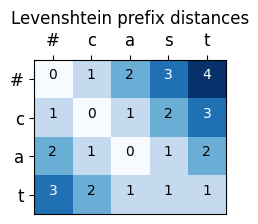

In [8]:
# Auxiliary function for drawing this matrix:
def plot_matrix(matrix, row_names, column_names, path=None, mods=None):
    """
    :param matrix: np.array [n_rows, n_cols] levenstein distance matrix
    :param row_names: Name of the row elements
    :param column_names: Name of the column elements
    :param path:
    :param mods:
    :return: None
    """
    row_names = ['#'] + list(row_names)
    column_names = ['#'] + list(column_names)
    matrix = np.array(matrix)

    plt.figure(figsize=(len(column_names) / 2, len(row_names) / 2))
    plt.imshow(matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title("Levenshtein prefix distances")

    r = 0 if max(map(len, row_names + column_names)) < 3 else 45
    plt.gca().xaxis.tick_top()
    plt.xticks(range(len(column_names)), column_names, fontsize=12, rotation=r)
    plt.yticks(range(len(row_names)), row_names, fontsize=12, rotation=r)

    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            kwargs = {
                'color': "white" if matrix[i, j] > matrix.max() / 2 else "black",
                'horizontalalignment': 'center'
            }
            plt.text(j, i, "{:,}".format(matrix[i, j]), **kwargs)

    if path is not None:
        for (i, j), mod in zip(path, mods):
            colors = {
                'same': '#888888',
                'subst': '#0000ff',
                'del': '#ff0000',
                'insert': '#00ff00'
            }

            rect = patches.Rectangle(
                (j - 0.45, i - 0.45), 0.9, 0.9,
                edgecolor=colors[mod], facecolor='none', linewidth=2)
            plt.gca().add_patch(rect)

    plt.show()


plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
], 'cat', 'cast')

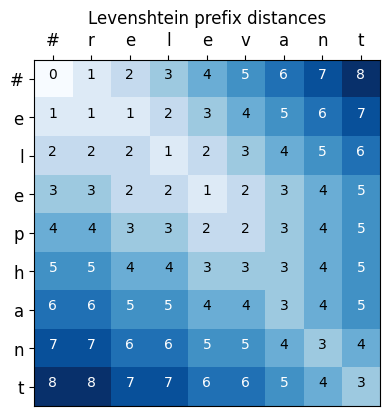

In [9]:
# first, second = 'sunday', 'saturday'
first, second = 'elephant', 'relevant'
plot_matrix(levenshtein_distance_matrix(first, second), first, second)

def run_tests(fn):
    assert fn('kitten', 'sitten') == 1
    assert fn('kitten', 'sit') == 4
    assert fn('kitten', 'puppy') == 6
    assert fn('bcabac', 'cabcab') == 3

    for _ in range(100):
        first = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        second = "".join([random.choice('abc') for _ in range(random.choice(range(3, 10)))])
        assert fn(first, second) == levenshtein_naive(first, second)

# lets check our implementation on random sequences
run_tests(levenshtein_dp)

### Backtrace

To understand what insertions, deletions and substitutions were made on the original sequence, you can do a backtrace on the resulting matrix. 

Let's consider the first sequence as the original one, abd we will call the deletions and inserts relative to it.

**Implement** the `backtrace` function, based on the construction logic `levenshtein_distance_matrix`:
* write the path to the variable `path` – the list of the coordinates of the matrix cells that lie on the optimal path through the matrix;
* and in the `mods` variable, write down the modifications that we make on the original sequence:
    * `same` - leaving the element unchanged
    * `subst` - replacing the element
    * `del` - deleting the element
    * `insert` - inserting the element

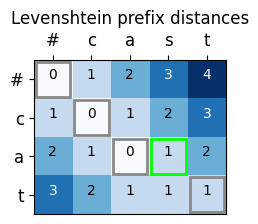

In [10]:
plot_matrix([
    [0, 1, 2, 3, 4],
    [1, 0, 1, 2, 3],
    [2, 1, 0, 1, 2],
    [3, 2, 1, 1, 1]
],
    'cat', 'cast',
    [(0, 0), (1, 1), (2, 2), (2, 3), (3, 4)],
    ['same', 'same', 'same', 'insert', 'same'])

In [11]:
def backtrace(d : np.ndarray):
    """Backtrace for Levenstein Distance

    :param d: Levenstein Distance matrix (np.ndarray)
    :return path:
    :return path:
    """
    path = []
    mods = []

    ##########################################
    # <YOUR CODE>
    i = d.shape[0] - 1
    j = d.shape[1] - 1
    while i > 0 or j > 0:
        path.append((i, j))
        if i == 0:
            mods.append('insert')
            j -= 1
        elif j == 0:
            mods.append('del')
            i -= 1
        else:
            min_d = min(d[i - 1, j], d[i, j - 1], d[i - 1, j - 1])
            if d[i - 1, j - 1] == min_d:
                if d[i, j] == min_d:
                    mods.append('same')
                else:
                    mods.append('subst')
                i -= 1
                j -= 1
            elif d[i - 1, j] == min_d:
                mods.append('del')
                i -= 1
            else:
                mods.append('insert')
                j -= 1
    path.append((0, 0))
    mods.append('same')
    path.reverse()
    mods.reverse()
    ##########################################

    return path, mods

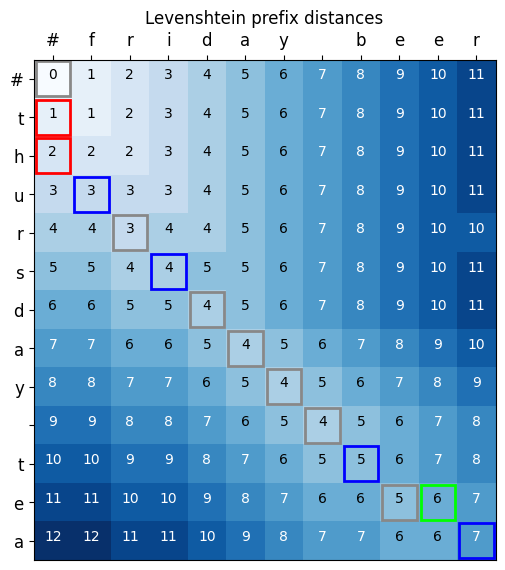

In [12]:
first, second = 'thursday tea', 'friday beer'

path, mods = backtrace(levenshtein_distance_matrix(first, second))
plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

Let's try applying the Levenshtein distance to a sequence of words, not characters.

S = 3	I = 1	D = 0


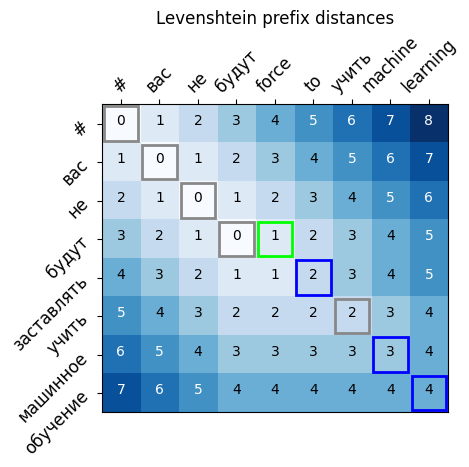

In [13]:
first = "вас не будут заставлять учить машинное обучение".split()
second = "вас не будут force to учить machine learning".split()
path, mods = backtrace(levenshtein_distance_matrix(first, second))

S = int((np.array(mods) == 'subst').sum())
I = int((np.array(mods) == 'insert').sum())
D = int((np.array(mods) == 'del').sum())
print(f"{S = }\t{I = }\t{D = }")
assert (S, I, D) == (3, 1, 0)

plot_matrix(levenshtein_distance_matrix(first, second), first, second, path, mods)

### Error Rate

In this part you will use the Levenstein distance which you implemented in the first part to obtain an measure of __mistmatch__ or __error__ between a reference and an ASR hypothesis at the word, character and phone level.

#### Theoretical Recap

Suppose we have our reference sequence, relative to which we want to calculate the recognition error.

Why do you think the Levenshtein distance is not suitable for measuring the quality of the ASR system because the number of tokens in sentence can be different. Therefore, we need to normalize the Levenshtein distance by the length of the reference. This years our minimum edit distance **rate**.

Word (character, phoneme, morpheme, syllable) error rate can then be computed as:

$$
\mathrm{WER} = \frac{\mathrm{S} + \mathrm{I} + \mathrm{D}}{\mathrm{N}}, \text{where:} \\
\text{S is the number of substitutions,} \\
\text{I is the number of insertions,} \\
\text{D is the number of deletions,} \\
\text{N is the length of reference.}
$$

We can assess the error rate between two sequences at multiple levels - the word level (WER), the character (letter) level (CER) and the phoneme level (PER). WER is the most strict, as even a partially correct word is considered incorrect. Phone Error rate is in some sense the most lenient, as is measures whether the reference and hypthesis "sound" the same. Note that error can be assessed at other levels, like morphemes, lexemes and syllables, for example. Which metric is appropriate depends on the choice of language and what is being measured.  

#### WER vs CER vs PER

Implement the `error_rate` function, which will calculate the prediction error for a given sequence of tokens (words, characters or phonemes) by formula above.

In [14]:
def error_rate(reference: Iterable, predicted: Iterable) -> float:
    assert len(reference) > 0

    ######################################
    # <YOUR CODE>
    return levenshtein_dp(reference, predicted) / len(reference)
    ######################################

In [15]:
# Assess error rate function

# Calculate WER and CER
first = "you will not be forced to learn machine learning"
second = "you'll not be forced to learn my sheen learning"

wer = np.round(error_rate(first.split(), second.split()), 4)
cer = np.round(error_rate(first, second), 4)

# Calculate PER - we provide a phonetic transcription of the above sentences.
first = grapheme_to_phoneme_model(first)
second = grapheme_to_phoneme_model(second)
print(first)
print(second)
per = np.round(error_rate(first, second), 4)

print('Word Error Rate:', wer)
print('Character Error Rate:', cer)
print('Phone Error Rate:', per)

assert np.allclose(wer, 0.4444, rtol=1e-5, atol=1e-5)
assert np.allclose(cer, 0.1875, rtol=1e-5, atol=1e-5)
assert np.allclose(per, 0.1316, rtol=1e-5, atol=1e-5)

['Y', 'UW1', ' ', 'W', 'IH1', 'L', ' ', 'N', 'AA1', 'T', ' ', 'B', 'IY1', ' ', 'F', 'AO1', 'R', 'S', 'T', ' ', 'T', 'UW1', ' ', 'L', 'ER1', 'N', ' ', 'M', 'AH0', 'SH', 'IY1', 'N', ' ', 'L', 'ER1', 'N', 'IH0', 'NG']
['Y', 'UW1', 'L', ' ', 'N', 'AA1', 'T', ' ', 'B', 'IY1', ' ', 'F', 'AO1', 'R', 'S', 'T', ' ', 'T', 'UW1', ' ', 'L', 'ER1', 'N', ' ', 'M', 'AY1', ' ', 'SH', 'IY1', 'N', ' ', 'L', 'ER1', 'N', 'IH0', 'NG']
Word Error Rate: 0.4444
Character Error Rate: 0.1875
Phone Error Rate: 0.1316


## Connectionist Temporal Classification (CTC)

### Lecture recap

#### Problem statement

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1FFGXZsCgy-uQfCBp7F4w1gaJbIGv6CV2" height="200px" width="700px">   -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/spectrogram_to_text.png" height="200px" width="700px">  

Define a modified label sequence $\omega'_{1:2L + 1}$:
- add blanks to the beginning and the end of the original label sequence $\omega_{1:L}$
- insert blanks between every pair of labels

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1CEhWtVYrSSkaRtEsJr5QwiH8lMaSQ_uN" height="150px" width="400px"> -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/grapheme_eps.png" height="150px" width="400px">


Define $\alpha_t(s)$ as the probability of all paths of length $t$ which go through state $\omega_s'$:

Denote a sequence of **acoustic features** or **observations** as

$$
    \mathbf{X}_{1:T} = \{x_1, \ldots, x_T\}
$$

Define a mapping $\mathcal{M}$ between words $\mathbf{w}$ and speech units $\omega_{1:L}$:

$$
    \{\omega^{(q)}_{1:L_q}\}^Q_{q = 1} = \mathcal{M}(\mathbf{w})
$$

$$
    \{\mathbf{w}^{(p)}\}^P_{p = 1} = \mathcal{M}^{-1}(\omega_{1:L})
$$

For some choices of speech units this mapping is not 1-to-1 ($Q > 1$, $P > 1$). A possible pair of text (green) and speech units (yellow):

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1HWD_SFZzids3Nz67BK_NQ5awkw6yUvLo" height="200px" width="600px"> -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/text_to_letters.png" height="200px" width="600px">

Automated speech recognition (ASR) is a **discriminative** task $\rightarrow$ "Which sequence $\mathbf{\hat w}$ is likely given the audio?":

$$
    \mathbf{\hat w} = \mathcal{M}^{-1}(\hat \omega_{1:L}), \quad \hat \omega_{1:L} = \arg \max_{\hat \omega_{1: L}} P(\hat \omega_{1:L} | \mathbf{X}_{1: T}; \theta),
$$

where $\theta$ denotes the parameters of the model we are building to solve the problem.

#### Discriminative state-space models

How feature vectors $\mathbf{X}_{1: T}$ and speech units $\omega_{1:L}$ relate or **align** to each other? Two common approaches to constructing models which can align:
- state-space models
- neural attention mechanisms

State-space models represent the space of various alignments in the form of a table (called **trellis**), the rows of which correspond to phonemes, and the columns are observed variables. One alignment is the path in this table from the upper left corner to the lower right.

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1npycuLvYq_-3p_xd6bouR21tfVeOvMUd" height="300px" width="600px"> -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/ctc_trellis.png" height="300px" width="600px">

Denote a set of all paths in trellis that map onto the phoneme sequence $\omega_{1:L}$ as $\mathcal{A}(\omega_{1:L})$, and let $\pi_{1:T} \in \mathcal{A}(\omega_{1:L})$ be an element of this set. Then a discriminative state-space system models $P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta)$ as 

$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} P(\pi_{1:T} | \mathbf{X}_{1:T}; \theta)
$$

Imagine that we have a recurrent neural network parametrized with $\theta$. The network outputs a distribution $P(z_t|x_t; \theta)$ over possible speech units $\omega$ for each frame $x_t$:

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=153E-ailMiLPg3joPSx016lGv6S4vXVD2" height="300px" width="550px"> -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/ctc_rnn.png" height="300px" width="550px">

CTC is a discriminative state-space model defined as:
    
$$
    P(\omega_{1:L} | \mathbf{X}_{1: T}; \theta) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L})} \prod_{t = 1}^T P(z_t = \pi_t| x_t; \theta)
$$
    
- CTC assumes all states conditionally independent
- Alignment free -- does not need prior alignment for training

### CTC Forward-Backward Algorithm


#### Forward Algorithm

$$
    \alpha_t(s) = P(\omega_{1:s/2}, \pi_t = \omega_s' | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{1:t - 1} \in \mathcal{A}(\omega_{1:s/2}), \, \pi_t = \omega_s'}  P(\pi_{1:t} | \mathbf{X}_{1:T}, \theta)
$$

Note that despite the fact that we have moved to the extended sequence $\omega'$, we are still interested in maximizing the probability of alignments to the original sequence. And step $s$ in the new sequence corresponds to step $s/2$ in the old sequence (rounded to the bottom).

The CTC forward algorithm recursively computes the forward variable $\alpha_t(s)$.

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1QaW0mJ9c3Z0KJVk3pUSyC_kS_pFC_QxS" height="400px" width="600px">   -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/ctc_trellis_alpha.png" height="400px" width="600px">  

**Initialization.** We allow all prefixes to start with either a blank ($\epsilon$) or the first symbol in $\omega_{1:L}$. Also note that $\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1$, because these variables correspond to states for which there are not enough time-steps left to complete the sequence.

This gives us the following rules for initialization:

$$
  \begin{aligned}
    &\alpha_t(0) = 0, \forall t & \\
    &\alpha_1(1) = P(z_1 = \epsilon | \mathbf{X}_{1:T}), &\\
    &\alpha_1(2) = P(z_1 = \omega^{'}_2 | \mathbf{X}_{1:T}), &\\
    &\alpha_1(s) = 0,\ \forall s > 2 &\\
    &\alpha_t(s) = 0,\ \forall s < (2L + 1) - 2(T - t) - 1 &  \text{top right zeros}\\
  \end{aligned}
$$

**Recursion.** 

$$
  \begin{aligned}
    &\alpha_t(s) = \left \{
  \begin{aligned}
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s-2}^{'} \\
    &\big(\alpha_{t-1}(s) + \alpha_{t-1}(s-1) + \alpha_{t-1}(s-2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$


<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1Tre3oFHyjigpqG-GI1xVrOchZAMnRYBK" height="250px" width="650px"> -->
<p style="text-align:center;"><img src="./images/ctc_alpha_step.png" height="250px" width="650px">

#### Backward Algorithm

Define $\beta_t(s)$ as the probability of all valid alignments $\omega'_{s:L}$ starting in state $\omega_s'$:

$$
    \beta_t(s) = P(\omega_{s/2:L}, \pi_t = \omega'_s | \mathbf{X}_{1:T}, \theta) = \sum_{\pi_{t + 1:T} \in \mathcal{A}(\omega_{s/2:L}), \, \pi_t = \omega_s'} P(\pi_{t + 1:T} | \mathbf{X}_{1:T}, \theta)
$$

The CTC backward algorithm recursively computes the backward variable $\beta_t(s)$:

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=11x3TGAzL2LWfO0ZKpPHegOvv8Iw6ZC0X" height="400px" width="600px"> -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/ctc_trellis_beta.png" height="400px" width="600px">


The formulas for backward algorithm are as follows:

$$
  \begin{aligned}
    &\beta_T(2L+1) = 1 &\\
    &\beta_T(2L) = 1 & \\
    &\beta_T(s) = 0, \forall s < 2L &\\
    &\beta_t(s) = 0,\ \forall s > 2t &\\
    &\beta_t(2L+2) = 0,\ \forall t  & \text{bottom left zeros} \\
    &\beta_t(s) = \left \{
  \begin{aligned}
    &\big(\beta_{t+1}(s) + \beta_{t+1}(s+1) \big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{if}\ \omega_s^{'} = \epsilon\ \text{or}\
    \omega_s^{'} = \omega_{s+2}^{'} \\
    &\big(\beta_{t+1}(s) +\beta_{t+1}(s+1) + \beta_{t+1}(s+2)\big) P(z_t = \omega^{'}_s | \mathbf{X}_{1:T}) & \text{otherwise}\\
  \end{aligned} \right. 
  \end{aligned}
$$

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1h7OBZZ02dwZ1mDhRYh7yTy7-UW4NmbXm" height="250px" width="650px">  -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/ctc_beta_step.png" height="350px" width="600px"> 

#### Alignment and Loss Computation

Use your newfound knowledge of the CTC forward-backward algorithm to obtain a soft-alignment

Remember, that the forward variable is computed as follows:

The probability of all paths passing through a state $\pi_t = \omega_s'$ is the product of forward and backward variables:

$$
    \alpha_t(s) \beta_t(s) = \sum_{\pi_{1:T} \in \mathcal{A}(\omega_{1:L}), \,\pi_t=\omega_s'} P(\pi_{1:T} | \mathbf{X}_{1:T}, \theta)
$$

Then, for any $t$, sum of all such products yields total probability:

$$
     \sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s) = P(\omega_{1:L} | \mathbf{X}_{1:T}, \theta)
$$

We can also use normalized $\alpha_t(s) \beta_t(s)$ as a measure of **soft-alignment**:

$$
    \text{align}_t(s) = \frac{\alpha_t(s) \beta_t(s)}{\sum_{s = 1}^{2 L + 1} \alpha_t(s) \beta_t(s)}
$$

You should get something like

<!-- <p style="text-align:center;"><img src="http://drive.google.com/uc?export=view&id=1HAIl9UPReiFQ7dNOZFGfvUWDurFDBZYM" height="300px" width="800px">  -->
<p style="text-align:center;"><img src="https://raw.githubusercontent.com/yandexdataschool/speech_course/main/week_04_asr/images/soft_align.png" height="300px" width="800px"> 

$$
  \text{align}_t(s) = \frac{\alpha_t(s)\beta_t(s)}{\sum_{s}\alpha_t(s)\beta_t(s)}
$$


Doing the computation in probability space can be numerically unstable, so you should do it in Log-Space using the
provided logsumexp operation. Remember to return to prob space at the end. 

### Implement CTC Forward Algorithm

In [16]:
NEG_INF = utils.NEG_INF
BLANK_SYMBOL = utils.BLANK_SYMBOL

tokenizer = utils.CTCTokenizer()

In [17]:
def forward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the forward pass of shape (2 * len(sequence) + 1, T)
    """
    # Turn probs into log-probs
    matrix = np.log(matrix)

    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = utils.modify_sequence(sequence, blank)

    # Initialze
    alphas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in range(matrix.shape[1]):
        for s in range(len(mod_sequence)):
            # First Step
            if t == 0:
                ########################
                # YOUR CODE HERE
                if s < 2:
                    alphas[s, t] = matrix[mod_sequence[s], t]
                else:
                    alphas[s, t] = NEG_INF
                ########################
            # Upper diagonal zeros
            elif s < len(mod_sequence) - 2 * (matrix.shape[1] - t) - 1: # CONDITION
                ########################
                # YOUR CODE HERE
                alphas[s, t] = NEG_INF
                ########################
            else:
                # Need to do this stabily
                if s == 0:
                    ########################
                    # YOUR CODE HERE
                    alphas[s, t] = alphas[s, t - 1] + matrix[mod_sequence[s], t]
                    ########################
                elif s == 1:
                    ########################
                    # YOUR CODE HERE
                    alphas[s, t] = utils.logsumexp(alphas[s - 1, t - 1], alphas[s, t - 1]) + matrix[mod_sequence[s], t]
                    ########################
                else:
                    ########################
                    # YOUR CODE HERE HINT - THERE IS ANOTHER IFELSE
                    if mod_sequence[s] == blank or mod_sequence[s] == mod_sequence[s - 2]:
                        alphas[s, t] = utils.logsumexp(alphas[s - 1, t - 1], alphas[s, t - 1]) + matrix[mod_sequence[s], t]
                    else:
                        alphas[s, t] = utils.logsumexp(alphas[s - 2, t - 1], alphas[s - 1, t - 1], alphas[s, t - 1]) + matrix[mod_sequence[s], t]
                    ########################
    return alphas

### Implement The CTC Backward Algorithm

In [18]:
def backward_algorithm(sequence: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    :param sequence: a string converted to an index array by Tokenizer
    :param matrix: A matrix of shape (K, T) with probability distributions over phonemes at each moment of time.
    :return: the result of the backward pass of shape (2 * len(sequence) + 1, T)
    """
    matrix = np.log(matrix)
    blank = tokenizer.get_symbol_index(BLANK_SYMBOL)
    mod_sequence = utils.modify_sequence(sequence, blank)
    betas = np.full([len(mod_sequence), matrix.shape[1]], NEG_INF)

    for t in reversed(range(matrix.shape[1])):
        for s in reversed(range(len(mod_sequence))):
            # First Step
            if t == matrix.shape[1] - 1:
                ########################
                # YOUR CODE HERE
                if s >= len(mod_sequence) - 2:
                    betas[s, t] = 0
                ########################
            # Lower Diagonal Zeros
            elif s + 1 > 2 * (t + 1) - 1:  # CONDITION
                ########################
                # YOUR CODE HERE
                betas[s, t] = NEG_INF
                ########################
            else:
                if s == len(mod_sequence) - 1:
                    ########################
                    # YOUR CODE HERE
                    betas[s, t] = betas[s, t + 1] + matrix[mod_sequence[s], t]
                    ########################
                elif s == len(mod_sequence) - 2:
                    ########################
                    # YOUR CODE HERE
                    betas[s, t] = utils.logsumexp(betas[s, t + 1], betas[s + 1, t + 1]) + matrix[mod_sequence[s], t]
                    ########################
                else:
                    ########################
                    # YOUR CODE HERE HINT - THERE IS ANOTHER IFELSE
                    if mod_sequence[s] == blank or mod_sequence[s] == mod_sequence[s + 2]:
                        betas[s, t] = utils.logsumexp(betas[s, t + 1], betas[s + 1, t + 1]) + matrix[mod_sequence[s], t]
                    else:
                        betas[s, t] = utils.logsumexp(betas[s, t + 1], betas[s + 1, t + 1], betas[s + 2, t + 1]) + matrix[mod_sequence[s], t]
                    ########################
    return betas

### Obtain Soft-Alignment


In [19]:
def soft_alignment(labels_indices: List[int], matrix: np.ndarray) -> np.ndarray:
    """
    Returns the alignment coefficients for the input sequence
    """
    alphas = forward_algorithm(labels_indices, matrix)
    betas = backward_algorithm(labels_indices, matrix)

    # Move from log space back to prob space
    align = np.exp(alphas + betas)

    # Normalize Alignment
    align = align / np.sum(align, axis=0, keepdims=True)

    return align

/var/folders/ld/h1xp0t916hdg081wwybzqlpcdp07pr/T/ipykernel_22738/3416173725.py:19: RuntimeWarning: divide by zero encountered in log
  im = ax[1].imshow(np.log(align), aspect='auto', cmap='viridis', interpolation='nearest')


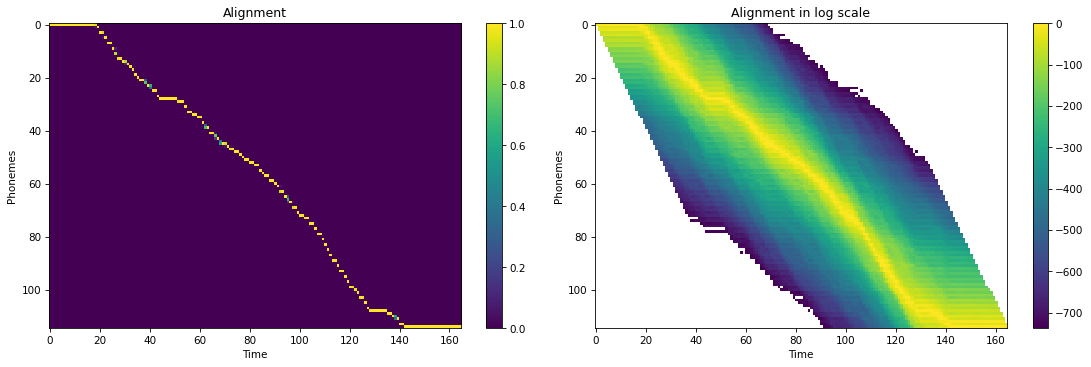

In [20]:
#!L
# Test your implementation

# Load numpy matrix, add axis [classes,time]
matrix = np.loadtxt(os.path.join(data_directory, 'test_matrix.txt'))

# Create label_sequence
labels_indices = tokenizer.text_to_indices('there se ms no good reason for believing that twillc ange')

align = soft_alignment(labels_indices, matrix)
f, ax = plt.subplots(1, 2, dpi=75, figsize=(15, 5))

im = ax[0].imshow(align, aspect='auto', cmap='viridis', interpolation='nearest')
ax[0].set_title("Alignment")
ax[0].set_ylabel("Phonemes")
ax[0].set_xlabel("Time")
f.colorbar(im, ax=ax[0])

im = ax[1].imshow(np.log(align), aspect='auto', cmap='viridis', interpolation='nearest')
ax[1].set_title("Alignment in log scale")
ax[1].set_ylabel("Phonemes")
ax[1].set_xlabel("Time")
f.colorbar(im, ax=ax[1])

plt.tight_layout()

ref_align = np.loadtxt(os.path.join(data_directory, 'soft_alignment.txt'))
assert np.allclose(ref_align, align)